In [1]:
# import os
# os.environ["TRITON_INTERPRET"] = "1"

In [1]:
import torch
from model_triton import t_scaled_dot_prod_attn_fwd, t_scaled_dot_prod_attn_bkwd3

#BS, H, N, D = 1, 1, 64, 128
#BS, H, N, D = 1, 1, 64, 64

BS, H, N, D = 1, 96, 512, 64
#BS, H, N, D = 8, 12, 512, 64
#BS, H, N, D = 1, 1, 512, 64
#BS, H, N, D = 2, 2, 128, 64 # -> out of resources for tiling along Q_N, but not along Q_N and K_T_N
#BS, H, N, D = 2, 2, 128, 32
#BS, H, N, D = 2, 2, 64, 32
#BS, H, N, D = 2, 2, 32, 16
#BS, H, N, D = 2, 2, 32, 32
#BS, H, N, D = 2, 2, 16, 16

dloss_dx = torch.randn((BS, H, N, D), device="cuda")
qkv = torch.randn((BS, H, 3, N, D), device="cuda")
#acts = [torch.randn((BS, H, N, N), device="cuda")]
mask = torch.tril(torch.ones((N,N), dtype=torch.bool, device="cuda")).unsqueeze(0).expand(BS, N, N)
#mask = torch.ones((N,N), dtype=torch.bool, device="cuda").unsqueeze(0).expand(BS, N, N)
#train=True
train=False #True
p_gen_aux = 42
N_RUNS = 1 #10

from model_triton import t_scaled_dot_prod_attn_fwd3
old_acts = t_scaled_dot_prod_attn_fwd3(qkv, mask, train, p_gen_aux)[1]

def fn_naive(qkv):
    return t_scaled_dot_prod_attn_bkwd3(dloss_dx, old_acts, qkv,  mask, train, p_gen_aux)
fn_jit = torch.compile(fn_naive)
#burn it
fn_jit(qkv) 
#fn_jit(dloss_dx, qkv) 

import time
t0 = time.time()
for _ in range(N_RUNS):
    result = fn_jit(qkv)
    #result = fn_jit(dloss_dx, qkv)
torch.cuda.synchronize()
t1 = time.time()
total = t1-t0
print(f'JIT total', total)

import time
t0 = time.time()
for _ in range(N_RUNS):
    result = fn_naive(qkv)
    #result = fn_naive(dloss_dx, qkv)
torch.cuda.synchronize()
t1 = time.time()
total = t1-t0
print(f'Naive total', total)

print(f'result', result[0].shape, result[1].shape, result[2].shape)
print('result', result[0].shape, result[0][:2,:2,-4:, -4:])
print('result', result[1].shape, result[1][:2,:2,-4:, -4:])
#print('result', result[2].shape, result[2][:2,:2,:4, :4])
print('result', result[2].shape, result[2][:2,:2,-4:, -4:])

JIT total 0.004426002502441406
Naive total 0.015705108642578125
result torch.Size([1, 96, 512, 64]) torch.Size([1, 96, 512, 64]) torch.Size([1, 96, 512, 64])
result torch.Size([1, 96, 512, 64]) tensor([[[[-4.9232e-02,  4.7414e-03, -1.1770e-01,  1.3947e-01],
          [-1.7000e-03, -1.9814e-02, -4.7261e-02,  1.7857e-02],
          [ 5.8569e-02, -1.4252e-02,  1.2132e-01, -3.2367e-02],
          [-3.8414e-02,  4.3345e-02, -7.3621e-02, -2.2131e-02]],

         [[ 4.9302e-02,  6.7095e-02, -1.1078e-04,  3.5220e-02],
          [ 3.3030e-02,  2.5750e-03, -1.2704e-01, -7.3808e-02],
          [ 6.3743e-02,  1.0924e-01,  4.5872e-02, -8.7987e-03],
          [ 5.4502e-02, -1.4580e-02, -1.8846e-02, -4.9602e-03]]]],
       device='cuda:0')
result torch.Size([1, 96, 512, 64]) tensor([[[[-3.2750e-05,  9.7217e-04,  1.2469e-03, -1.1621e-04],
          [-2.1688e-03, -9.2686e-04, -2.8752e-03,  1.1310e-03],
          [-3.6520e-03,  6.1378e-05,  1.8289e-03,  2.8583e-03],
          [-2.8767e-04,  7.4431e-05, 

In [73]:
import triton
import triton.language as tl

from model_triton import gelu_k, T_DROPOUT_RATE, dropout_k, dropout_bkwd2_k

# This will work for moderate size of D: it's tiling along N dimension of Q, and along N dimension of K_T.
# It doesn't tile along D dimension.
# Different program per BS_H item (reshape of BS and H in one dim, and one program per this dim)
@triton.jit
def t_scaled_dot_prod_attn_bkwd3_k(dloss_dx_ptr, q_ptr, k_t_ptr, v_ptr, output_ptr, mask_ptr, acts0_ptr, acts1_ptr,
                dloss_dq_ptr, dloss_dk_ptr, dloss_dv_ptr,
                dloss_dx_stride0, dloss_dx_stride1, dloss_dx_stride2,
                q_stride0, q_stride1, q_stride2, k_t_stride0, k_t_stride1, k_t_stride2,
                v_stride0, v_stride1, v_stride2, output_stride0, output_stride1, output_stride2, 
                mask_stride0, mask_stride1, acts0_stride0, acts1_stride0,
                dloss_dq_stride0, dloss_dq_stride1, dloss_dq_stride2,                                                                      
                dloss_dk_stride0, dloss_dk_stride1, dloss_dk_stride2,                                   
                dloss_dv_stride0, dloss_dv_stride1, dloss_dv_stride2,
                train, p_gen_aux,
                BS_H, N, D,
                BLOCK_SIZE_Q_N: tl.constexpr, BLOCK_SIZE_K_T_N: tl.constexpr, BLOCK_SIZE_D: tl.constexpr,
                num_stages: tl.constexpr
                ):
    # Matching PyTorch's fp32 dtype ( see https://github.com/triton-lang/triton/issues/4574)
    ASM: tl.constexpr = "cvt.rna.tf32.f32 $0, $1;"
    
    sqrt_D = tl.sqrt(D.to(tl.float32)) # TODO T: extract from this method?
    bs_h_start = tl.program_id(0)
    bs_h_step = tl.num_programs(0)
    for bs_h_pid in tl.range(bs_h_start, BS_H, bs_h_step, num_stages):
        bs_h_dloss_dx_ptr = dloss_dx_ptr + bs_h_pid * dloss_dx_stride0      
        bs_h_q_ptr = q_ptr + bs_h_pid * q_stride0
        bs_h_k_t_ptr = k_t_ptr + bs_h_pid * k_t_stride0    
        bs_h_v_ptr = v_ptr + bs_h_pid * v_stride0        
        bs_h_output_ptr = output_ptr + bs_h_pid * output_stride0        
        bs_h_acts0_ptr = acts0_ptr + bs_h_pid * acts0_stride0           
        bs_h_acts1_ptr = acts1_ptr + bs_h_pid * acts1_stride0                   
        bs_h_dloss_dq_ptr = dloss_dq_ptr + bs_h_pid * dloss_dq_stride0
        bs_h_dloss_dk_ptr = dloss_dk_ptr + bs_h_pid * dloss_dk_stride0
        bs_h_dloss_dv_ptr = dloss_dv_ptr + bs_h_pid * dloss_dv_stride0

        d_offsets = tl.arange(0, BLOCK_SIZE_D)
        d_offsets_mod = d_offsets %D
        
        for k_t_n_step in range(0, tl.cdiv(N, BLOCK_SIZE_K_T_N)):
            
            # Load K_T and V blcks
            k_t_n_offsets = k_t_n_step * BLOCK_SIZE_K_T_N + tl.arange(0, BLOCK_SIZE_K_T_N) 
            k_t_n_offsets_mod = k_t_n_offsets % N
            k_blck_ptr = bs_h_k_t_ptr + d_offsets_mod[:,None] * k_t_stride1 + k_t_n_offsets_mod[None, :] * k_t_stride2
            k_blck_mask = (d_offsets[:, None] < D) & (k_t_n_offsets[None, :] < N)
            k_blck = tl.load(k_blck_ptr, mask=k_blck_mask, other=0.0) # TODO T: rename to k_t_blck!
            k_blck = tl.inline_asm_elementwise(ASM, "=r, r", [k_blck], dtype=tl.float32, is_pure=True, pack=1)
            v_blck_ptr = bs_h_v_ptr + k_t_n_offsets_mod[:,None] * v_stride1 + d_offsets_mod[None, :] * v_stride2
            v_blck_mask = (k_t_n_offsets[:, None] < N) & (d_offsets[None, :]<D)
            v_blck = tl.load(v_blck_ptr, mask=v_blck_mask, other=0.0)
            v_blck = tl.inline_asm_elementwise(ASM, "=r, r", [v_blck], dtype=tl.float32, is_pure=True, pack=1)
            
            dloss_dk_blck = tl.zeros((BLOCK_SIZE_K_T_N, BLOCK_SIZE_D), dtype=tl.float32)
            dloss_dv_blck = tl.zeros((BLOCK_SIZE_K_T_N, BLOCK_SIZE_D), dtype=tl.float32)   
            
            # ASSUMES CAUSAL MASK FOR NOW 
            # This is somehow limited suppport for now. I only tested this for
            # a) BLOCK_SIZE_K_T_N = BLOCK_SIZE_Q_N and BLOCK_SIZE_K_T_N = 2x BLOCK_SIZE_Q_N
            q_n_step_start = max(0, k_t_n_step * tl.cdiv(BLOCK_SIZE_K_T_N,BLOCK_SIZE_Q_N))
            
            for q_n_step in range(q_n_step_start, tl.cdiv(N, BLOCK_SIZE_Q_N)):          
                q_n_offsets = q_n_step * BLOCK_SIZE_Q_N + tl.arange(0, BLOCK_SIZE_Q_N)            
                q_n_offsets_mod = q_n_offsets % N # TODO T: Do I need modulo n, modulo m operations? 

                # Load Q blck
                q_blck_ptr = bs_h_q_ptr + q_n_offsets_mod[:,None] * q_stride1 + d_offsets_mod[None, :] * q_stride2
                q_blck_mask = (q_n_offsets[:,None] < N) & (d_offsets[None, :] < D)
                q_blck = tl.load(q_blck_ptr, mask=q_blck_mask, other=0.0)
                q_blck = tl.inline_asm_elementwise(ASM, "=r, r", [q_blck], dtype=tl.float32, is_pure=True, pack=1)

                # Load softmax logits' max and sumexp
                attn_max = tl.load(bs_h_acts0_ptr+ q_n_offsets_mod, mask=q_n_offsets < N, other=-1e9)
                attn_max = attn_max.expand_dims(1)
                attn_logits_sumexp = tl.load(bs_h_acts1_ptr+ q_n_offsets_mod, mask=q_n_offsets < N, other=0.0)            
                attn_logits_sumexp = attn_logits_sumexp.expand_dims(1)

                # Precompute row-wise sum of dloss_dx * output
                dloss_dx_blck_ptr = bs_h_dloss_dx_ptr + q_n_offsets_mod[:,None] * dloss_dx_stride1 + d_offsets_mod[None, :] * dloss_dx_stride2
                dloss_dx_blck_mask = (q_n_offsets[:, None] < N) & (d_offsets[None, :]<D)
                input_dloss_dx_blck = tl.load(dloss_dx_blck_ptr, mask=dloss_dx_blck_mask, other=0.0)
                input_dloss_dx_blck = tl.inline_asm_elementwise(ASM, "=r, r", [input_dloss_dx_blck], dtype=tl.float32, is_pure=True, pack=1)
                output_blck_ptr = bs_h_output_ptr + q_n_offsets_mod[:,None] * output_stride1 + d_offsets_mod[None, :] * output_stride2
                output_blck_mask = (q_n_offsets[:, None] < N) & (d_offsets[None, :]<D)
                output_blck = tl.load(output_blck_ptr, mask=output_blck_mask, other=0.0)
                output_blck = tl.inline_asm_elementwise(ASM, "=r, r", [output_blck], dtype=tl.float32, is_pure=True, pack=1)
                rowise_dloss_dx_output_sum = tl.sum(input_dloss_dx_blck * output_blck, axis=1, keep_dims=True)

                # Compute "Q * K^T / sqrt(D) + Mask + Softmax + Dropout", and backpropagate
                attn = tl.dot(q_blck, k_blck) / sqrt_D
                mask_blck_ptr = mask_ptr + q_n_offsets_mod[:,None] * mask_stride0 + k_t_n_offsets_mod[None, :] * mask_stride1
                mask_mask = (q_n_offsets[:,None] <N) & (k_t_n_offsets[None, :]<N)
                mask_blck = tl.load(mask_blck_ptr, mask=mask_mask, other= 0.0)
                attn = tl.where(mask_blck, attn, -1e9)
                sa_pre_dropout = tl.exp(attn - attn_max)/attn_logits_sumexp
                # TODO T: confirm that this is different enough seed per row (assumes that D_PID always equals to 0)
                sa = dropout_k(sa_pre_dropout, train, p_gen_aux+bs_h_pid, q_n_offsets[:,None] + k_t_n_offsets[None, :])

                # Propagate back
                # dloss_dv=torch.einsum(f'cd, ce -> ed', dloss_dx, sa), dloss_dx is Q_N x D, sa is Q_N x K_T_N
                dloss_dv_blck = tl.dot(tl.trans(sa), input_dloss_dx_blck, dloss_dv_blck)
                # dloss_dx = torch.einsum(f'cd, ed -> ce', dloss_dx, v)
                dloss_dx_blck = tl.dot(input_dloss_dx_blck, tl.trans(v_blck)) 
                dloss_dx_blck = dloss_dx_blck * sa + rowise_dloss_dx_output_sum * -sa_pre_dropout
                # TODO T: For small speedup, replace the above with: (we need an access to zs though)
                #dloss_dx_blck = sa_pre_dropout * ( dloss_dx_blck * zs - rowise_dloss_dx_output_sum)
                dloss_dx_blck = tl.where(mask_blck, dloss_dx_blck, 0) # Q_N x K_T_N
                # dloss_dq = torch.matmul(dloss_dx, k/math.sqrt(D))
                dloss_dq_blck = tl.dot(dloss_dx_blck, tl.trans(k_blck)/sqrt_D) # TODO T: rename k_blck into k_t_blck!
                dloss_dq_mask = (q_n_offsets[:,None] <N) & (d_offsets[None, :]<D)
                dloss_dq_blck_ptr = bs_h_dloss_dq_ptr + q_n_offsets[:,None] * dloss_dq_stride1 + d_offsets[None, :] * dloss_dq_stride2                
                tl.atomic_add(dloss_dq_blck_ptr, dloss_dq_blck, mask=dloss_dq_mask)                
                # dloss_dk = torch.einsum('abcd, abce->abde', dloss_dx/math.sqrt(D), q)
                dloss_dk_blck = tl.dot(tl.trans(dloss_dx_blck)/sqrt_D, q_blck, dloss_dk_blck)
            
            dloss_dv_blck_ptr = bs_h_dloss_dv_ptr + k_t_n_offsets[:,None] * dloss_dv_stride1 + d_offsets[None, :] * dloss_dv_stride2
            dloss_dv_mask = (k_t_n_offsets[:,None] <N) & (d_offsets[None, :]<D)
            tl.store(dloss_dv_blck_ptr, dloss_dv_blck, mask=dloss_dv_mask)
            
            dloss_dk_blck_ptr = bs_h_dloss_dk_ptr + k_t_n_offsets[:,None] * dloss_dk_stride1 + d_offsets[None, :] * dloss_dk_stride2                
            dloss_dk_mask = (k_t_n_offsets[:,None] <N) & (d_offsets[None, :]<D)
            tl.store(dloss_dk_blck_ptr, dloss_dk_blck, mask=dloss_dk_mask)
                

def n_t_scaled_dot_prod_attn_bkwd3_t(dloss_dx, acts, qkv:torch.Tensor, mask:torch.Tensor, train=True, p_gen_aux=None):
    q, k, v = torch.unbind(qkv, dim=2) # BS x H x N x D
    BS, H, N, D = q.shape
    
    dloss_dx = dloss_dx.reshape(BS*H, N, D)
    q = q.reshape(BS*H, N, D)
    k = k.reshape(BS*H, N, D)
    v = v.reshape(BS*H, N, D)
    mask = mask[0] # Asumme mask being the same across rows. TODO XXX: make that assumption throughput the code
    acts0, acts1, output = acts
    acts0 = acts0.reshape(BS*H, N)
    acts1 = acts1.reshape(BS*H, N)    
    output = output.reshape(BS*H, N, D)
    
    dloss_dq = torch.zeros_like(q)
    dloss_dk = torch.zeros_like(k)
    dloss_dv = torch.zeros_like(v)    
    
    # TODO T: check if some matrices are contiguous?
    grid = (min(BS*H, 80),) # TODO T: We can bump it up to 160?

    # Tuned params given num_warps=8, and BS, H, N, D = 8, 12, 512, 64
    num_warps = 8
    num_stages = 2 # TODO T: I don't think this helps
    # TODO T: We have more memory to use, but smaller block_size use sparsity of causal mask better 
    BLOCK_SIZE_Q_N = 32  
    BLOCK_SIZE_K_T_N = 32 
    BLOCK_SIZE_D = triton.next_power_of_2(D)
    
    # We enforce causal masking for now, but the assert below cost too much perf
    #assert torch.allclose(mask, torch.tril(torch.ones((N, N), device=mask.device, dtype=torch.bool))), "Assumes causal mask"
    assert BLOCK_SIZE_K_T_N>= BLOCK_SIZE_Q_N, "Due to the limited support for levarging causal mask"

    if not train:
        p_gen_aux = 0 # Need to mock some value for triton to compile the kernel without errors
    k_t = torch.transpose(k, -2, -1)
    t_scaled_dot_prod_attn_bkwd3_k[grid](
        dloss_dx, q, k_t, v, output, mask, acts0, acts1,
        dloss_dq, dloss_dk, dloss_dv,
        dloss_dx.stride(0), dloss_dx.stride(1), dloss_dx.stride(2),
        q.stride(0), q.stride(1), q.stride(2), k_t.stride(0), k_t.stride(1), k_t.stride(2), 
        v.stride(0), v.stride(1), v.stride(2),
        output.stride(0), output.stride(1), output.stride(2),        
        mask.stride(0), mask.stride(1), acts0.stride(0), acts1.stride(0),
        dloss_dq.stride(0), dloss_dq.stride(1), dloss_dq.stride(2),        
        dloss_dk.stride(0), dloss_dk.stride(1), dloss_dk.stride(2),
        dloss_dv.stride(0), dloss_dv.stride(1), dloss_dv.stride(2),
        train, p_gen_aux,
        BS*H, N, D,
        BLOCK_SIZE_Q_N=BLOCK_SIZE_Q_N, BLOCK_SIZE_K_T_N = BLOCK_SIZE_K_T_N, BLOCK_SIZE_D=BLOCK_SIZE_D,
        num_warps=num_warps, num_stages=num_stages)
    
    return dloss_dq.reshape(BS, H, N, D), dloss_dk.reshape(BS, H, N, D), dloss_dv.reshape(BS, H, N, D)

from model_triton import n_t_scaled_dot_prod_attn_fwd3_t
output, new_acts = n_t_scaled_dot_prod_attn_fwd3_t(qkv, mask, train, p_gen_aux) # note new_acts contains output 
def fn_t(qkv):
    return n_t_scaled_dot_prod_attn_bkwd3_t(dloss_dx, new_acts, qkv, mask, train, p_gen_aux)

# Burn it 
fn_t(qkv)

import time
t0 = time.time()
for _ in range(N_RUNS):
    result2 = fn_t(qkv)
    #result = fn_t(dloss_dx, qkv)
torch.cuda.synchronize()
t1 = time.time()
total = t1-t0
print(f'total', total)
print('result2', result2[0].shape, result2[0][:2, :2, -4:, -4:])
print('result2', result2[1].shape, result2[1][:2, :2, -4:, -4:])
#print('result2', result2[2].shape, result2[2][:2, :2, :4, :4])
print('result2', result2[2].shape, result2[2][:2, :2, -4:, -4:])

assert torch.allclose(result[0], result2[0], rtol=5e-2, atol=3e-3), (result[0].shape, result2[0].shape, result[0][:2, :2, -4:, -4:], result2[0][:2, :2, -4:, -4:])
assert torch.allclose(result[1], result2[1], rtol=5e-2, atol=2e-3), (result[1].shape, result2[1].shape, result[1][:2, :2, -4:, -4:], result2[1][:2, :2, -4:, -4:])
assert torch.allclose(result[2], result2[2], rtol=5e-2, atol=2e-3), (result[2].shape, result2[2].shape, result[2][:2, :2, -4:, -4:], result2[2][:2, :2, -4:, -4:])

#assert torch.allclose(result[0], result2[0], rtol=5e-2, atol=4e-4), (result[0].shape, result2[0].shape, result[0][:2, :2, -4:, -4:], result2[0][:2, :2, -4:, -4:])
#assert torch.allclose(result[2], result2[2], rtol=5e-2, atol=4e-4), (result[2].shape, result2[2].shape, result[2][:2, :2, -4:, -4:], result2[2][:2, :2, -4:, -4:])

#assert torch.allclose(result, result2, rtol=1e-1, atol=1e-3), (result.shape, result2.shape, result[:2, :2, :4, :4], result2[:2, :2, :4, :4])
#assert torch.allclose(result, result2, rtol=3e-2, atol=4e-4), (result.shape, result2.shape, result[:2, :2, -4:, -4:], result2[:2, :2, -4:, -4:])
#assert torch.allclose(result, result2, rtol=1e-2, atol=5e-4), (result.shape, result2.shape, result[:2, :2, -4:, -4:], result2[:2, :2, -4:, -4:])

loc(callsite("/efs/notebooks/mkukla/pre-tjax/model_triton.py":1438:7 at "/tmp/ipykernel_12532/2621160587.py":102:74)): error: operation scheduled before its operands


total 0.005916118621826172
result2 torch.Size([1, 96, 512, 64]) tensor([[[[-4.9226e-02,  4.7485e-03, -1.1770e-01,  1.3940e-01],
          [-1.6826e-03, -1.9838e-02, -4.7215e-02,  1.7882e-02],
          [ 5.8574e-02, -1.4250e-02,  1.2127e-01, -3.2352e-02],
          [-3.8434e-02,  4.3308e-02, -7.3618e-02, -2.2128e-02]],

         [[ 4.9304e-02,  6.7095e-02, -1.3039e-04,  3.5181e-02],
          [ 3.3015e-02,  2.5725e-03, -1.2698e-01, -7.3759e-02],
          [ 6.3670e-02,  1.0921e-01,  4.5921e-02, -8.7934e-03],
          [ 5.4475e-02, -1.4566e-02, -1.8852e-02, -4.9302e-03]]]],
       device='cuda:0')
result2 torch.Size([1, 96, 512, 64]) tensor([[[[-3.2711e-05,  9.7113e-04,  1.2450e-03, -1.1634e-04],
          [-2.1691e-03, -9.2687e-04, -2.8752e-03,  1.1312e-03],
          [-3.6514e-03,  6.1223e-05,  1.8280e-03,  2.8576e-03],
          [-2.8752e-04,  7.4393e-05,  4.4367e-04,  3.6839e-04]],

         [[ 1.7765e-03, -1.3946e-03, -2.3073e-03,  1.8882e-03],
          [ 7.2131e-04,  2.3466e-02,

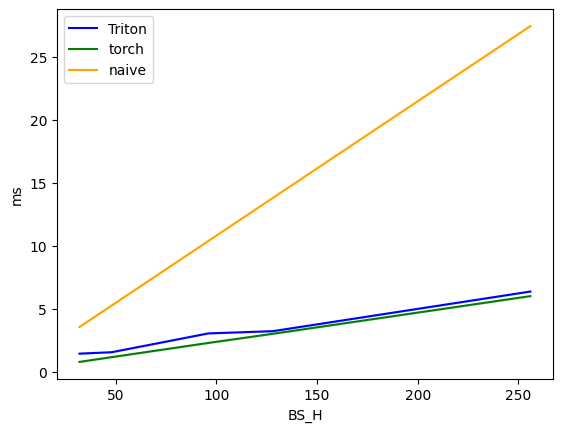

t_scaled_dot_prod_attn_fwd_t:
    BS_H    Triton     torch      naive
0   32.0  1.456000  0.799280   3.574848
1   48.0  1.568416  1.177520   5.275648
2   96.0  3.061440  2.303232  10.398016
3  128.0  3.239136  3.029792  13.815472
4  256.0  6.385632  6.022528  27.465696


In [74]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['BS_H'],  # Argument names to use as an x-axis for the plot.
        x_vals=[32, 48, 96, 128, 256],
        #x_vals=[96],
        #x_vals=[128 * 2**i for i in range(0, 6)],
        #x_vals=[128 * i for i in range(2, 33)],  # Different possible values for `x_name`.
        #x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch', 'naive'],  # Possible values for `line_arg`.
        line_names=['Triton', 'torch', 'naive'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # Line styles.
        ylabel='ms',  # Label name for the y-axis.
        plot_name='t_scaled_dot_prod_attn_fwd_t',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
        # TODO T: Use real M i.e. 
    ))
def benchmark(BS_H, provider):
    #BS, H, N, D = 1, BS_H, 32, 16
    #BS, H, N, D = 8, 12, 512, 64
    BS, H, N, D = 1, BS_H, 512, 64 
    dloss_dx = torch.randn((BS, H, N, D), device="cuda")
    qkv = torch.randn((BS, H, 3, N, D), device="cuda")  
    
    old_acts = t_scaled_dot_prod_attn_fwd3(qkv, mask, train, p_gen_aux)[1]
    def fn_naive(qkv):
        return t_scaled_dot_prod_attn_bkwd3(dloss_dx, old_acts, qkv,  mask, train, p_gen_aux)
    fn_jit = torch.compile(fn_naive)
    output, new_acts = n_t_scaled_dot_prod_attn_fwd3_t(qkv, mask, train, p_gen_aux) # note new_acts contains output 
    def fn_t(qkv):
        return n_t_scaled_dot_prod_attn_bkwd3_t(dloss_dx, new_acts, qkv, mask, train, p_gen_aux)

    
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_jit(qkv), quantiles=quantiles)
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_jit(dloss_dx, x), quantiles=quantiles)
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_jit(aa, bb), quantiles=quantiles)
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_t(aa, bb), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_t(qkv), quantiles=quantiles)        
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_t(dloss_dx, x), quantiles=quantiles)
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_t(aa, bb), quantiles=quantiles)
    if provider == 'naive':
       ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_naive(qkv), quantiles=quantiles)
       #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_naive(dloss_dx, x), quantiles=quantiles)
    #perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3) # TODO XXX: investigate whether this is right. In the tutorial they operate on different dtype
    perf = lambda ms: ms
    return perf(ms), perf(max_ms), perf(min_ms)
benchmark.run(print_data=True, show_plots=True)

In [64]:
import torch
print(torch.cuda.get_device_properties("cuda"))
from triton.runtime import driver
device = torch.cuda.current_device()
properties = driver.active.utils.get_device_properties(device)
NUM_SM = properties["multiprocessor_count"]
SIZE_SMEM = properties["max_shared_mem"]
NUM_REGS = properties["max_num_regs"]
WARP_SIZE = properties["warpSize"] # Not 64 as A100
properties

_CudaDeviceProperties(name='NVIDIA A10G', major=8, minor=6, total_memory=22723MB, multi_processor_count=80, uuid=61ea3d2d-53a8-44f6-4844-0bcc29aa720b, L2_cache_size=6MB)


{'max_shared_mem': 101376,
 'max_num_regs': 65536,
 'multiprocessor_count': 80,
 'warpSize': 32,
 'sm_clock_rate': 1710000,
 'mem_clock_rate': 6251000,
 'mem_bus_width': 384}

In [65]:
num_stages = 4 if SIZE_SMEM > 200000 else 2
num_warps = 8
print(f'num_stages', num_stages, 'num_warps', num_warps)

q, k, v = torch.unbind(qkv, dim=2) # BS x H x N x D
BS, H, N, D = q.shape

dloss_dx = dloss_dx.reshape(BS*H, N, D)
q = q.reshape(BS*H, N, D)
k = k.reshape(BS*H, N, D)
v = v.reshape(BS*H, N, D)
temp_mask = mask[0] # Asumme mask being the same across rows. TODO XXX: make that assumption throughput the code
acts0, acts1, _ = new_acts
acts0 = acts0.reshape(BS*H, N)
acts1 = acts1.reshape(BS*H, N)    
temp_output = output.reshape(BS*H, N, D)
dloss_dq = torch.zeros_like(q)
dloss_dk = torch.zeros_like(k)
dloss_dv = torch.zeros_like(v)    

BLOCK_SIZE_Q_N = 32 #64 #128
BLOCK_SIZE_K_T_N = 32 #64
BLOCK_SIZE_D = triton.next_power_of_2(D)

if not train:
    p_gen_aux = 0 # Need to mock some value for triton to compile the kernel without errors
k_t = torch.transpose(k, -2, -1)
kernel = t_scaled_dot_prod_attn_bkwd3_k.warmup(
    dloss_dx, q, k_t, v, temp_output, temp_mask, acts0, acts1,
    dloss_dq, dloss_dk, dloss_dv,
    dloss_dx.stride(0), dloss_dx.stride(1), dloss_dx.stride(2),
    q.stride(0), q.stride(1), q.stride(2), k_t.stride(0), k_t.stride(1), k_t.stride(2), 
    v.stride(0), v.stride(1), v.stride(2),
    temp_output.stride(0), temp_output.stride(1), temp_output.stride(2),        
    mask.stride(0), mask.stride(1), acts0.stride(0), acts1.stride(0),
    dloss_dq.stride(0), dloss_dq.stride(1), dloss_dq.stride(2),        
    dloss_dk.stride(0), dloss_dk.stride(1), dloss_dk.stride(2),
    dloss_dv.stride(0), dloss_dv.stride(1), dloss_dv.stride(2),
    train, p_gen_aux,
    BS*H, N, D,
    BLOCK_SIZE_Q_N=BLOCK_SIZE_Q_N, BLOCK_SIZE_K_T_N = BLOCK_SIZE_K_T_N, BLOCK_SIZE_D=BLOCK_SIZE_D,
    grid=(1, ), num_warps=num_warps, num_stages=num_stages)

kernel._init_handles()
n_regs = kernel.n_regs
size_smem = kernel.metadata.shared
print(f'n_regs', n_regs, 'size_smem', size_smem)

occupancy = NUM_REGS // (n_regs * WARP_SIZE * num_warps)
print(f'occupancy', occupancy, SIZE_SMEM // size_smem)
occupancy = min(occupancy, SIZE_SMEM // size_smem)
num_programs = NUM_SM * occupancy
print(f'num_programs', num_programs)

num_stages 2 num_warps 8
n_regs 255 size_smem 41088
occupancy 1 2
num_programs 80


In [ ]:
32
2080
4128
6176